In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [2]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def thermPulse(psi0, t, Omega0, delPrime, eta, nbar, Ncut): #1-dimensional
    result = psi(0.0+0.0j,0.0+0.0j)
    for n in range(Ncut):
        result += prob(n,nbar)*pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0
    return result

def therm3DPulse(psi0, t, Omega0, delPrime, nbars, Omegas, Ncut):
    nbarx = nbars[0]
    nbary = nbars[1]
    nbarz = nbars[2]
    #Ncut = 100
    result = psi(0.0+0.0j,0.0+0.0j)
    for nx in range(Ncut):
        Probx = prob(nx,nbarx)
        for ny in range(Ncut):
            Probxy = Probx*prob(ny,nbary)
            for nz in range(Ncut):
                result += Probxy*prob(nz,nbarz)*pulse(t, Omega0*Omegas[nx,ny,nz], delPrime, 0.0, 0.0)@psi0
    return result

def rhoee(psi):
    return (abs(psi[1]))**2.0

def rhogg(psi):
    return (abs(psi[0]))**2.0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [3]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n

def expE(nbar, omega, Ncut):
    expE = 0.0
    #Ncut = 1001
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def expEHeat(nbar0, nbarf, omega, Ncut):
    return expE((nbar0+nbarf)/2.0, omega, Ncut)

hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

omega = 2.0*np.pi*778e3 #Lange
Omegarf = 2.0*np.pi*13e6 #Lange
m = 170.936331517*amutokg
beta = 0.0
alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)

In [4]:
def RamseyErrSig(deld, psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf, Ncut):
    #nbar = nbar0 + nbardot*T
    delPrime = deld - Delta
    freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
    intState = thermPulse(psi0, t1, Omega0, delPrime, eta, nbar0, Ncut)
    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delPrime, eta, nbarf, Ncut)
    return rhoee(resultP) - rhoee(resultM)

In [24]:
Ncut = 501
psi0 = psi(0.0, 1.0)
Delta = 0.23  #hz
Omega0 = 20.0*2.0*np.pi #hz
nbar0 = 0.0 
nbarf = 0.0
t1 = np.pi/(2.0*Omega0)
t2 = 5.0*np.pi/(2.0*Omega0)
T = 50.0e-3
eta = 0.05

tol = 1.0e-10
x0 = -0.1
x1 = 0.5

pts = 10
delds = np.linspace(-10.0, 10.0, pts)
errSigPts = np.zeros(pts,)
RhoeeM = np.zeros(pts,)
RhoeeP = np.zeros(pts,)
dif = np.zeros(pts,)
for ii in range(pts):
    print(ii)
    errSigPts[ii] = RamseyErrSig(delds[ii], psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf, Ncut)

0
1
2
3
4
5
6
7
8
9


In [26]:
tol = 1.0e-10
x0 = -0.5
x1 = 0.5
shift = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root


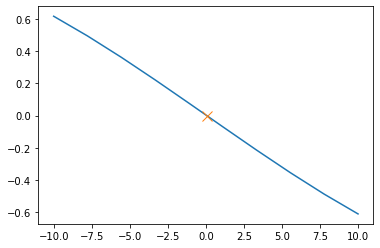

In [27]:
plt.plot(delds, errSigPts)
plt.plot([shift],[0.0],marker="x",markersize=10)

In [28]:
shift

0.055339542851014334

In [19]:
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
nu0*1e-18*1e3

0.6883589793093079

In [43]:
pts = 15
nbarfs = np.linspace(0, 40, pts)
Ncut = 501
psi0 = psi(0.0, 1.0)
Delta = 0.01*2.0*np.pi #hz
Omega0 = 50.0*2.0*np.pi #hz
nbar0 = 0.0 
t1 = np.pi/(2.0*Omega0)
t2 = np.pi/(2.0*Omega0)
T = 500.0e-3
eta = 0.05

shifts = np.zeros(pts)
tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 2.0

for ii in range(pts):
    print(nbarfs[ii])
    shifts[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, Delta, Omega0, eta, nbar0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts[ii])
    x0 = shifts[ii] - guessTol
    x1 = shifts[ii] + guessTol
    #print(x0,x1)

0.0
0.0007893867573977027
2.857142857142857
0.0007878274185636068
5.714285714285714
0.0007863124979807869
8.571428571428571
0.0007848405297548821
11.428571428571429
0.0007834100956738787
14.285714285714286
0.0007820198243905035
17.142857142857142
0.0007806683905284054
20.0
0.000779354513653789
22.857142857142858
0.0007780769573060886
25.714285714285715
0.0007768345280840032
28.571428571428573
0.000775626075649247
31.42857142857143
0.0007744504945305116
34.285714285714285
0.0007733067287221943
37.142857142857146
0.0007721937788641272
40.0
0.0007711107106378879


In [13]:
pts = 15
nbarfs = np.linspace(0, 40, pts)
Ncut = 1201
nbar0 = 0.0
shift1s = np.zeros(pts)
shift1s = -expEHeat(nbar0, nbarfs, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))

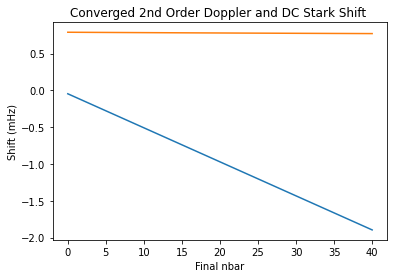

In [44]:
plt.plot(nbarfs,shift1s*nu0*1.0e3, label="Ncut=1201")
plt.plot(nbarfs, shifts*1e3)
plt.xlabel("Final nbar")
plt.ylabel("Shift (mHz)")
plt.title("Converged 2nd Order Doppler and DC Stark Shift ")
plt.show()

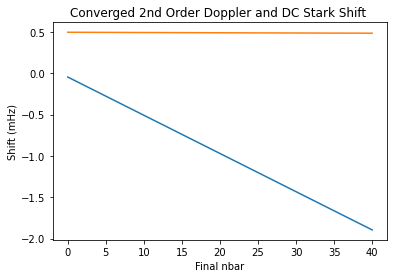

In [16]:
plt.plot(nbarfs,shift1s*nu0*1.0e3, label="Ncut=1201")
plt.plot(nbarfs, shifts*1e3)
plt.xlabel("Final nbar")
plt.ylabel("Shift (mHz)")
plt.title("Converged 2nd Order Doppler and DC Stark Shift ")
plt.show()

In [17]:
print(shifts)

[0.0004957  0.00049472 0.00049376 0.00049283 0.00049193 0.00049105
 0.0004902  0.00048937 0.00048857 0.00048778 0.00048702 0.00048628
 0.00048556 0.00048486 0.00048417]


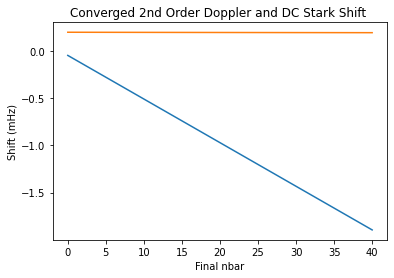

In [19]:
plt.plot(nbarfs,shift1s*nu0*1.0e3, label="Ncut=1201")
plt.plot(nbarfs, shifts*1e3)
plt.xlabel("Final nbar")
plt.ylabel("Shift (mHz)")
plt.title("Converged 2nd Order Doppler and DC Stark Shift ")
plt.show()

In [20]:
0.0004957-0.00048417

1.1529999999999939e-05

In [21]:
print(shifts)

[0.00019922 0.00019883 0.00019844 0.00019807 0.0001977  0.00019735
 0.000197   0.00019667 0.00019634 0.00019603 0.00019572 0.00019542
 0.00019513 0.00019484 0.00019457]


In [26]:
shifts = np.array([0.0004957,  0.00049472 ,0.00049376, 0.00049283 ,0.00049193, 0.00049105,
 0.0004902 , 0.00048937 ,0.00048857 ,0.00048778 ,0.00048702, 0.00048628,
 0.00048556, 0.00048486, 0.00048417])

ValueError: x and y must have same first dimension, but have shapes (15,) and (100,)

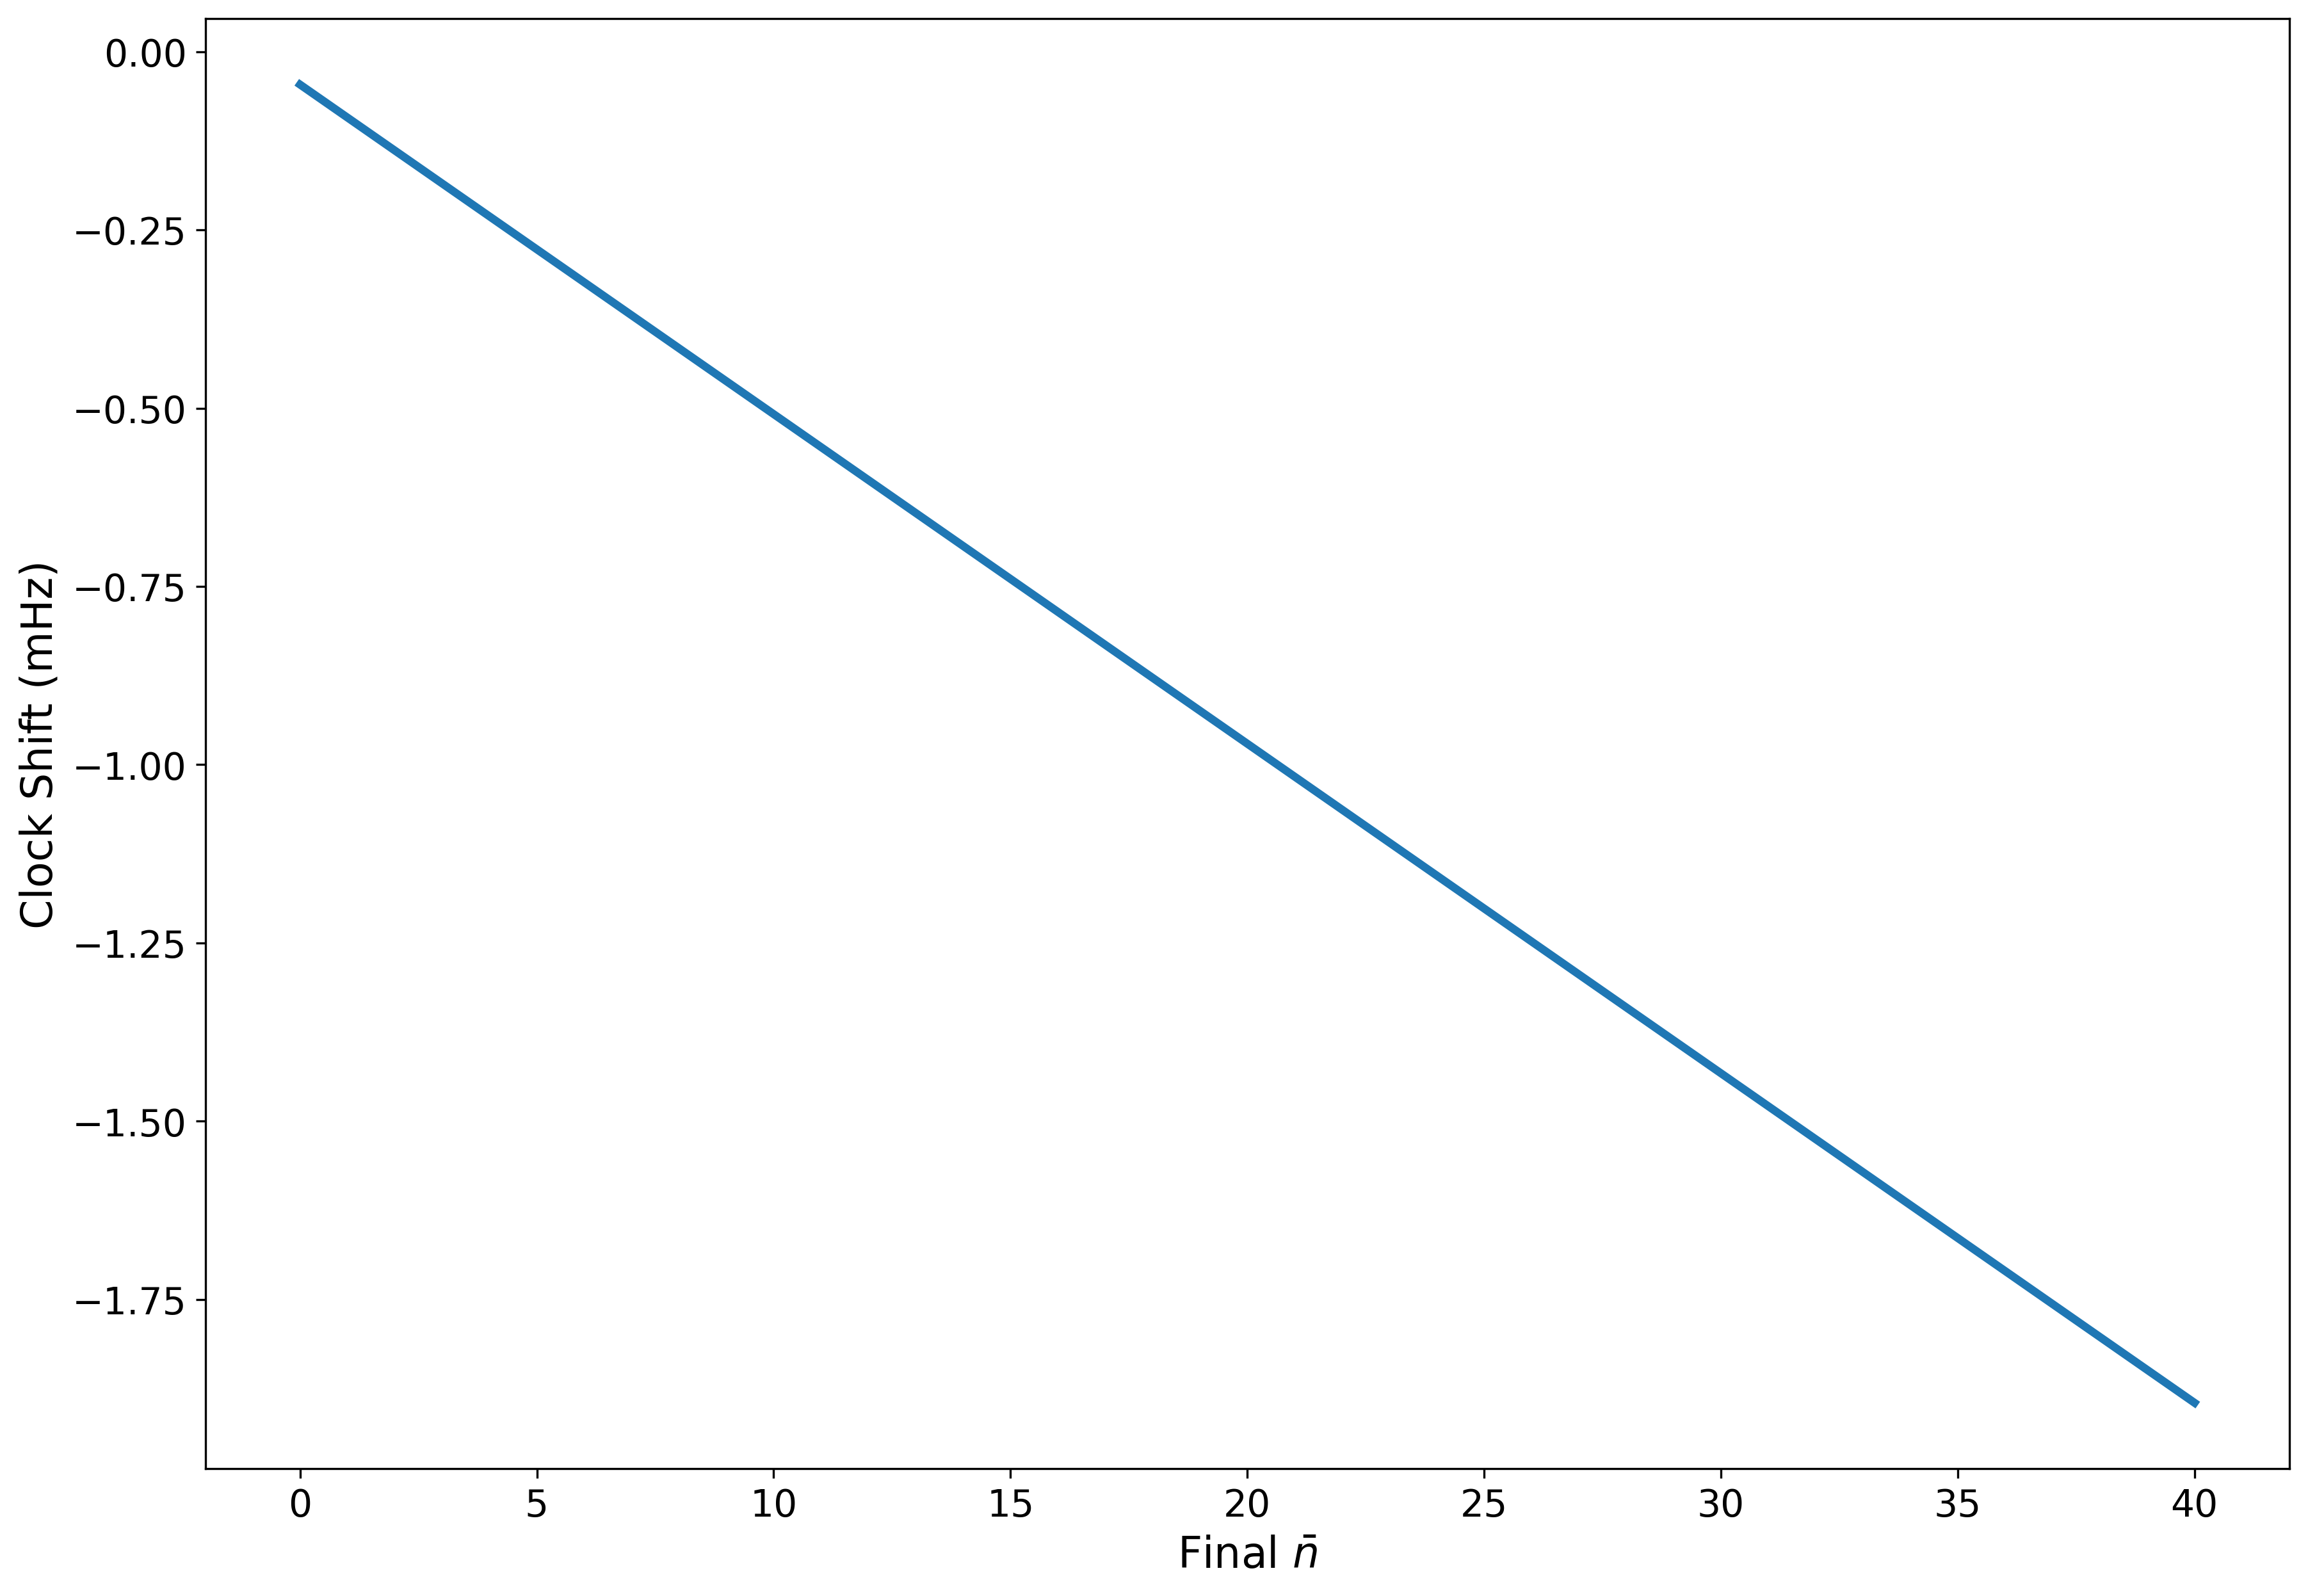

In [160]:
plt.figure(dpi=300)
plt.xlabel(r'Final $\bar{n}$', fontsize="16")
plt.ylabel('Clock Shift (mHz)', fontsize="16")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.plot(nbarfs,shift1s*nu0*1.0e3, label="Doppler and Stark Shifts",linewidth=3)
plt.plot(nbarfs, shifts*1e3, label="Probe-Light Shift",linewidth=3)
plt.legend(fontsize=12)
plt.show()

In [36]:
pts = 15
nbarf = 0.0
Ncut = 501
psi0 = psi(0.0, 1.0)
deltas = np.linspace(-1,1,pts)  #0.1*2.0*np.pi #hz
Omega0 = 50.0*2.0*np.pi #hz
nbar0 = 0.0 
t1 = np.pi/(2.0*Omega0)
t2 = np.pi/(2.0*Omega0)
T = 200.0e-3
eta = 0.05

shifts = np.zeros(pts)
tol = 1.0e-11
x0 = -0.1
x1 = 0.5
guessTol = 2.0

for ii in range(pts):
    print(delPrimes[ii])
    shifts[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, deltas[ii], Omega0, eta, nbar0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts[ii])
    x0 = shifts[ii] - guessTol
    x1 = shifts[ii] + guessTol

-0.5
-0.015413871054737033
-0.25
-0.007706936163538478
0.0
-1.6445586822140708e-14
0.25
0.00770693616350494
0.5
0.01541387105471913


In [37]:
(-0.015413871054737033+0.007706936163538478)/0.25

-0.03082773956479422

In [34]:
2.0/(Omega0*T)

0.03183098861837907

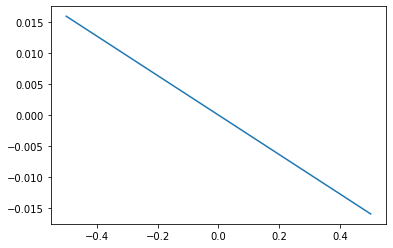

In [35]:
plt.plot(delPrimes, shifts)

In [156]:
pts = 100
nbarf = 0.0
Ncut = 2
psi0 = psi(0.0, 1.0)
Deltas = np.linspace(0,0.5, pts)  #0.1*2.0*np.pi #hz
Omega0 = 1.0 #10.0*2.0*np.pi #hz
nbar0 = 0.0 
t1 = np.pi/(2.0*Omega0)
t2 = np.pi/(2.0*Omega0)
T = 20.0
eta = 0.00

shifts = np.zeros(pts)
tol = 1.0e-11
x0 = -0.01
x1 = 0.1
guessTol = 0.1

for ii in range(pts):
    #print(Deltas[ii])
    shifts[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, Deltas[ii], Omega0, eta, nbar0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts[ii])
    x0 = shifts[ii]# - guessTol
    x1 = shifts[ii] + guessTol

3.184974494156636e-14
0.00045913640084495723
0.0009182702711928321
0.0013773990804365219
0.0018365202984885753
0.0022956313958191464
0.002754729843641571
0.00321381311409805
0.0036728786804450563
0.004131924017238514
0.00459094660051896
0.005049943907996181
0.0055089134192338966
0.005967852615833857
0.006426758981619766
0.00688563000282081
0.007344463168254766
0.007803255969510748
0.00826200590113138
0.00872071046079467
0.00917936714949521
0.009637973471724879
0.010096526935653058
0.010555025053306166
0.011013465340746568
0.011471845318250856
0.011930162510487492
0.012388414446693627
0.012846598660851295
0.013304712691862787
0.013762754083725208
0.014220720385704289
0.014678609152507283
0.01513641794445501
0.015594144327653029
0.01605178587416186
0.0165093401621662
0.016966804776143315
0.017424177307030206
0.01788145535239003
0.018338636516577165
0.01879571841090141
0.01925269865379102
0.019709574870954674
0.020166344695542068
0.020623005768303684
0.021079555737749115
0.021535992260304

In [151]:
t1 = np.pi/(2.0*Omega0)
t2 = 3.0*np.pi/(2.0*Omega0)

shift2s = np.zeros(pts)
tol = 1.0e-8
x0 = -0.01
x1 = 0.01
guessTol = 0.1

for ii in range(pts):
    #print(Deltas[ii])
    print([x0,x1])
    shift2s[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, Deltas[ii], Omega0, eta, nbar0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
    print(shifts[ii])
    x0 = shift2s[ii]# - guessTol
    x1 = shift2s[ii] + guessTol
    print([x0, x1])

[-0.01, 0.01]
3.184974494156636e-14
[0.0, 0.1]
[0.0, 0.1]
-0.142354429879479
[2.023443122802077e-08, 0.10000002023443123]
[2.023443122802077e-08, 0.10000002023443123]
-0.28479102106782084
[1.6183822143943813e-07, 0.10000016183822144]
[1.6183822143943813e-07, 0.10000016183822144]
-0.42738593863700686
[5.45994750315174e-07, 0.10000054599475032]
[5.45994750315174e-07, 0.10000054599475032]
-0.8575406436375935
[1.2935161958740569e-06, 0.10000129351619588]
[1.2935161958740569e-06, 0.10000129351619588]
-1.001248665499591
[2.5246598192481736e-06, 0.10000252465981925]
[2.5246598192481736e-06, 0.10000252465981925]
-1.1452888960672285
[4.358946495664658e-06, 0.10000435894649568]
[4.358946495664658e-06, 0.10000435894649568]
-1.58003848758486
[6.914982213291453e-06, 0.1000069149822133]
[6.914982213291453e-06, 0.1000069149822133]
-1.7252436037943377
[1.0310283239266411e-05, 0.10001031028323927]
[1.0310283239266411e-05, 0.10001031028323927]
-1.8706792125783662
[1.4661105624081842e-05, 0.1000146611056

In [158]:
shift3s = np.array([0.2369269551243633,
 0.22621480197925117,
 0.21571745045483118,
 0.20543848700262607,
 0.19538154215179382,
 0.18555028101894996,
 0.1759483928494155,
 0.16657957916986205,
 0.15744753969646996,
 0.1485559576414526,
 0.1399084833264351,
 0.13150871593877675,
 0.12336018283106387,
 0.11546631755214185,
 0.1078304366618395,
 0.10045571198919788,
 0.09334514404460786,
 0.08650153017137202,
 0.07992743269354104,
 0.07362514375150205,
 0.06759664823766799,
 0.061843585133552585,
 0.056367205843329424,
 0.05116833229362962,
 0.04624731168802827,
 0.0416039720410481,
 0.03723757538199427,
 0.03314677082281559,
 0.029329548472538557,
 0.025783192883245664,
 0.022504239473491894,
 0.019488431541249185,
 0.016730680538341397,
 0.014225030968897046,
 0.011964629612863067,
 0.009941699383780343,
 0.008147521303966659,
 0.0065724229868501325,
 0.005205775622278449,
 0.004036000396125021,
 0.0030505846440791835,
 0.002236107627861216,
 0.0015782777518033846,
 0.0010619810279459024,
 0.0006713380962610229,
 0.00038977502379566864,
 0.00020010054111481738,
 8.459417521951787e-05,
 2.5102591142080705e-05,
 3.140607848757425e-06,
 0.0,
 -3.140607848757425e-06,
 -2.510259114204635e-05,
 -8.459417521955208e-05,
 -0.00020010054111481738,
 -0.00038977502379566864,
 -0.0006713380962610229,
 -0.0010619810279458685,
 -0.0015782777518034182,
 -0.0022361076278611825,
 -0.003050584644079216,
 -0.004036000396125021,
 -0.005205775622278449,
 -0.006572422986850167,
 -0.008147521303966626,
 -0.009941699383780377,
 -0.011964629612863067,
 -0.014225030968897046,
 -0.01673068053834143,
 -0.01948843154124915,
 -0.02250423947349193,
 -0.02578319288324563,
 -0.029329548472538592,
 -0.03314677082281559,
 -0.03723757538199424,
 -0.04160397204104812,
 -0.04624731168802826,
 -0.05116833229362966,
 -0.056367205843329424,
 -0.06184358513355255,
 -0.067596648237668,
 -0.07362514375150203,
 -0.07992743269354106,
 -0.08650153017137202,
 -0.09334514404460786,
 -0.10045571198919788,
 -0.10783043666183947,
 -0.11546631755214187,
 -0.12336018283106387,
 -0.13150871593877675,
 -0.1399084833264351,
 -0.14855595764145257,
 -0.15744753969646996,
 -0.16657957916986205,
 -0.17594839284941557,
 -0.18555028101894996,
 -0.19538154215179382,
 -0.20543848700262607,
 -0.21571745045483118,
 -0.22621480197925117,
 -0.2369269551243633])

ValueError: x and y must have same first dimension, but have shapes (100,) and (101,)

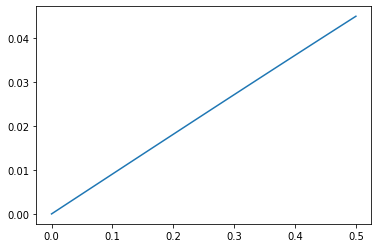

In [159]:
plt.plot(Deltas, shifts)
plt.plot(Deltas, shift3s)